In [1]:
import os
import numpy as np
import pywt
import random
import seaborn as sns
import tensorflow as tf
from keras.layers import Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
  Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, 
  Dense, Dropout, GRU, Concatenate, LayerNormalization, MultiHeadAttention, 
  Reshape, Multiply, Softmax
)
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from utils import (
  encode_labels, check_gpu_availability, plot_loss_accuracytupian, 
  evaluate_model, plot_confusion_matrixtupian, plot_tsne, 
  plot_precision_recall_curve_multiclasstupian, plot_roc_curve_multiclasstupian, 
  AdjustLearningRateCallback, denoise2,count_labels,denoise2_iterative2,AdjustLearningRateCallback
)
from utils import plot_precision_recall_curve_multiclass,plot_roc_curve_multiclass2,calculate_g_mean,plot_confusion_matrix,plot_confusion_matrix2,plot_loss_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1DTranspose


c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
check_gpu_availability()

GPU 可用


In [3]:
datafilename1 = "C:\\Users\\Administrator\\Desktop\\database\\cinc2017denoise.npz"
data1 = np.load(datafilename1, allow_pickle=True)
X_train, y_train, X_val, y_val, X_test, y_test = data1['ecgstrain'], data1['labelstrain'], data1['ecgsval'], data1['labelsval'], data1['ecgstest'], data1['labelstest']

In [4]:
y_train = encode_labels(y_train)
y_test = encode_labels(y_test)
y_val= encode_labels(y_val)
y_train = to_categorical(y_train, num_classes=4)
y_val=to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.models import Model

def residual_block(x, filters, kernel_size, strides):
    shortcut = x
    # 主卷积路径
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # 如果shortcut的形状与x不匹配，则调整shortcut
    if shortcut.shape[-1] != x.shape[-1] or shortcut.shape[-2] != x.shape[-2]:
        shortcut = Conv1D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # 添加跳过连接
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(32, 31, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual blocks
    x = residual_block(x, 32, 31, 2)
    x = residual_block(x, 64, 17, 2)
    x = residual_block(x, 128, 9, 2)
    x = residual_block(x, 256, 5, 2)

    # Classifier
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

# Example usage:
model =resnet((4500, 1), 4)
model.summary()


c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
import tensorflow as tf

def weighted_crossentropy(weights):
    def loss(y_true, y_pred):
        # 计算未加权的交叉熵损失
        unweighted_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
        # 应用类别权重
        weighted_loss = unweighted_loss * weights
        # 返回加权损失
        return weighted_loss
    return loss
class_weights = [2.0, 1.0, 1.5, 1.0] 

In [8]:
callback = AdjustLearningRateCallback(factor=0.1, patience=2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer='Adam', loss=weighted_crossentropy(class_weights), metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=128, epochs=80, validation_data=(X_val, y_val), callbacks=[callback,early_stopping])

Epoch 1/80
110/110 [==============================] - 15s 50ms/step - loss: 1.0603 - accuracy: 0.6561 - val_loss: 1.0396 - val_accuracy: 0.6605
Epoch 2/80
110/110 [==============================] - 4s 38ms/step - loss: 0.8534 - accuracy: 0.7300 - val_loss: 0.9164 - val_accuracy: 0.6997
Epoch 3/80
110/110 [==============================] - 4s 38ms/step - loss: 0.7934 - accuracy: 0.7543 - val_loss: 0.8251 - val_accuracy: 0.7477
Epoch 4/80
110/110 [==============================] - 4s 39ms/step - loss: 0.7504 - accuracy: 0.7678 - val_loss: 0.8198 - val_accuracy: 0.7471
Epoch 5/80
110/110 [==============================] - 4s 39ms/step - loss: 0.7236 - accuracy: 0.7803 - val_loss: 0.7965 - val_accuracy: 0.7619
Epoch 6/80
110/110 [==============================] - 4s 39ms/step - loss: 0.6996 - accuracy: 0.7883 - val_loss: 0.7557 - val_accuracy: 0.7624
Epoch 7/80
110/110 [==============================] - 4s 39ms/step - loss: 0.6737 - accuracy: 0.7951 - val_loss: 0.7452 - val_accuracy: 0.771

In [17]:
evaluate_model(model,X_test,y_test)

Precision: 0.8237366315750647
Recall: 0.8431901423389585
F1 Score: 0.8317914883535291
Accuracy: 0.8632341110217217
Class 1 - Precision: 0.8235294117647058, Recall: 0.9251101321585903, F1 Score: 0.8713692946058091
Class 2 - Precision: 0.8889602053915276, Recall: 0.9227181878747501, F1 Score: 0.9055246812683884
Class 3 - Precision: 0.8205521472392638, Recall: 0.7249322493224932, F1 Score: 0.7697841726618705
Class 4 - Precision: 0.7619047619047619, Recall: 0.8, F1 Score: 0.7804878048780488
Class 1 Accuracy: 0.9750603378921963
Class 2 Accuracy: 0.8837489943684634
Class 3 Accuracy: 0.8712791633145616
Class 4 Accuracy: 0.996379726468222


In [18]:
y_pred_classes = np.argmax(model.predict(X_test), axis=-1)
y_test_classes = np.argmax(y_test, axis=1)

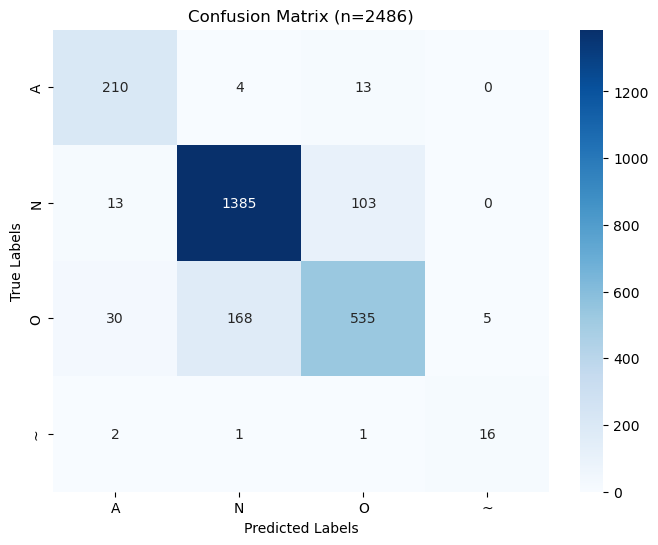

In [19]:
plot_confusion_matrix2(y_test_classes, y_pred_classes, classes=['A', 'N', 'O', '~'])